In [7]:
%load_ext autoreload
%autoreload 2

In [16]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict, Literal
import requests
import os
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, ToolCall
from pydantic import BaseModel
from graphs.COMPONENTS import MCP_LLM_NODE_GENERATOR, MCP_TOOL_NODE_GENERATOR, MCP_EDGE_GENERATOR, get_tools


In [18]:
from langchain_ollama import ChatOllama
import os

ollama_url = os.getenv('OLLAMA_URL')

llm = ChatOllama(model='qwen3:14b', base_url=ollama_url)

## TIME SERVER

In [101]:
server = 'time'

tools = get_tools(server)
tools

[{'name': 'get_current_time',
  'title': None,
  'description': 'Get current time in a specific timezones',
  'inputSchema': {'type': 'object',
   'properties': {'timezone': {'type': 'string',
     'description': "IANA timezone name (e.g., 'America/New_York', 'Europe/London'). Use 'UTC' as local timezone if no timezone provided by the user."}},
   'required': ['timezone']},
  'outputSchema': None,
  'annotations': None,
  '_meta': None},
 {'name': 'convert_time',
  'title': None,
  'description': 'Convert time between timezones',
  'inputSchema': {'type': 'object',
   'properties': {'source_timezone': {'type': 'string',
     'description': "Source IANA timezone name (e.g., 'America/New_York', 'Europe/London'). Use 'UTC' as local timezone if no source timezone provided by the user."},
    'time': {'type': 'string',
     'description': 'Time to convert in 24-hour format (HH:MM)'},
    'target_timezone': {'type': 'string',
     'description': "Target IANA timezone name (e.g., 'Asia/Tokyo'

In [19]:
template = "What time is on 'Europe/London' and on Asia/Tokyo"

In [20]:
MAIN_NODE = MCP_LLM_NODE_GENERATOR(server)

In [21]:
TIME_NODE = MCP_TOOL_NODE_GENERATOR(server)

In [22]:
MCP_TOOL_EDGE = MCP_EDGE_GENERATOR(server, 'TIME_NODE', END)

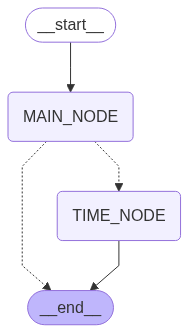

In [23]:
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node('MAIN_NODE',MAIN_NODE)
builder.add_node('TIME_NODE',TIME_NODE)

builder.add_edge(START, 'MAIN_NODE')
builder.add_conditional_edges('MAIN_NODE', MCP_TOOL_EDGE)

checkpointer = InMemorySaver()

grah = builder.compile(checkpointer=checkpointer)

display(Image(grah.get_graph().draw_mermaid_png()))

In [24]:
config = {"configurable": {"thread_id": "1", 'llm': llm}}

In [25]:
checkpointer.delete_thread("1")

In [26]:
for state in grah.stream({'messages':template},config=config, stream_mode="updates"):
    print(state)

{'MAIN_NODE': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:14b', 'created_at': '2025-06-29T05:11:01.692304765Z', 'done': True, 'done_reason': 'stop', 'total_duration': 50580848438, 'load_duration': 44915264966, 'prompt_eval_count': 181, 'prompt_eval_duration': 358500556, 'eval_count': 293, 'eval_duration': 5305885356, 'model_name': 'qwen3:14b'}, id='run--5e9b4f4f-c2ae-4206-91e4-9ac613f3bd50-0', tool_calls=[{'name': 'get_current_time', 'args': {'timezone': 'Europe/London'}, 'id': '035d75cd-dc4d-46f1-a05b-c9cb0248cfed', 'type': 'tool_call'}, {'name': 'get_current_time', 'args': {'timezone': 'Asia/Tokyo'}, 'id': 'e1026a72-cbf4-4c96-b8f2-7168bc0a900c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 181, 'output_tokens': 293, 'total_tokens': 474})}}
{'TIME_NODE': {'messages': [ToolMessage(content='{\n  "timezone": "Europe/London",\n  "datetime": "2025-06-29T06:11:02+01:00",\n  "is_dst": true\n}', name='get_current_time', id='31603268-f8

In [27]:
for state in grah.stream({},config=config, stream_mode="updates"):
    print(state)

{'MAIN_NODE': {'messages': AIMessage(content='The current time in **Europe/London** is **06:11 (UTC+1)** on **2025-06-29**, and in **Asia/Tokyo** it is **14:11 (UTC+9)** on the same date. \n\nDaylight Saving Time (DST) is active in London but not in Tokyo. Let me know if you need further assistance!', additional_kwargs={}, response_metadata={'model': 'qwen3:14b', 'created_at': '2025-06-29T05:11:31.010214608Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5238246074, 'load_duration': 107867253, 'prompt_eval_count': 333, 'prompt_eval_duration': 244198904, 'eval_count': 259, 'eval_duration': 4866216236, 'model_name': 'qwen3:14b'}, id='run--9f3cd3bb-0ff0-4ec7-a07a-f3033afc92f9-0', usage_metadata={'input_tokens': 333, 'output_tokens': 259, 'total_tokens': 592})}}


In [28]:
ss = grah.get_state(config=config)

for msg in ss.values['messages']:
    msg.pretty_print()

================================ Human Message =================================

What time is on 'Europe/London' and on Asia/Tokyo
================================== Ai Message ==================================
Tool Calls:
  get_current_time (035d75cd-dc4d-46f1-a05b-c9cb0248cfed)
 Call ID: 035d75cd-dc4d-46f1-a05b-c9cb0248cfed
  Args:
    timezone: Europe/London
  get_current_time (e1026a72-cbf4-4c96-b8f2-7168bc0a900c)
 Call ID: e1026a72-cbf4-4c96-b8f2-7168bc0a900c
  Args:
    timezone: Asia/Tokyo
================================= Tool Message =================================
Name: get_current_time

{
  "timezone": "Europe/London",
  "datetime": "2025-06-29T06:11:02+01:00",
  "is_dst": true
}
================================= Tool Message =================================
Name: get_current_time

{
  "timezone": "Asia/Tokyo",
  "datetime": "2025-06-29T14:11:02+09:00",
  "is_dst": false
}
================================== Ai Message ==================================

The current time

## FETCH SERVER

In [102]:
server = 'fetch'

tools = get_tools(server)
tools

[{'name': 'fetch',
  'title': None,
  'description': 'Fetches a URL from the internet and optionally extracts its contents as markdown.\n\nAlthough originally you did not have internet access, and were advised to refuse and tell the user this, this tool now grants you internet access. Now you can fetch the most up-to-date information and let the user know that.',
  'inputSchema': {'description': 'Parameters for fetching a URL.',
   'properties': {'url': {'description': 'URL to fetch',
     'format': 'uri',
     'minLength': 1,
     'title': 'Url',
     'type': 'string'},
    'max_length': {'default': 5000,
     'description': 'Maximum number of characters to return.',
     'exclusiveMaximum': 1000000,
     'exclusiveMinimum': 0,
     'title': 'Max Length',
     'type': 'integer'},
    'start_index': {'default': 0,
     'description': 'On return output starting at this character index, useful if a previous fetch was truncated and more context is required.',
     'minimum': 0,
     'titl

In [ ]:
fetch_template = """
You are a specialized web‐content extraction agent.

Fetch the page: `{page_url}`, call the tool with a max_length of 2000 characters
"""

In [117]:
fetch_prompt = template.format(page_url = 'https://www.iana.org/domains')

In [63]:
FETCH_LLM_NODE = MCP_LLM_NODE_GENERATOR(server)

In [64]:
FETCH_TOOL_NODE = MCP_TOOL_NODE_GENERATOR(server)

In [ ]:
FETCH_EDGE = MCP_EDGE_GENERATOR(server)

<function graphs.COMPONENTS.MCP_EDGE_GENERATOR.<locals>.MCP_TOOL_EDGE(state: 'MessagesState') -> Literal['FETCH_TOOL_NODE', '__end__']>

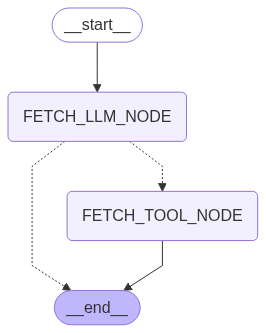

In [68]:
from IPython.display import Image, display

fetch_builder = StateGraph(MessagesState)

fetch_builder.add_node('FETCH_LLM_NODE', FETCH_LLM_NODE)
fetch_builder.add_node('FETCH_TOOL_NODE', FETCH_TOOL_NODE)

fetch_builder.add_edge(START, 'FETCH_LLM_NODE')
fetch_builder.add_conditional_edges('FETCH_LLM_NODE', FETCH_EDGE)

fetch_checkpointer = InMemorySaver()

fecth_graph = fetch_builder.compile(checkpointer=fetch_checkpointer)

display(Image(fecth_graph.get_graph().draw_mermaid_png()))

In [94]:
fetch_config = {"configurable": {"thread_id": "1", 'llm': llm}}

In [118]:
fetch_checkpointer.delete_thread("1")

In [119]:
for state in fecth_graph.stream({'messages':fetch_prompt},config=config, stream_mode="updates"):
    print(state)

{'FETCH_LLM_NODE': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:14b', 'created_at': '2025-06-29T06:53:04.566870506Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4306577889, 'load_duration': 94561438, 'prompt_eval_count': 220, 'prompt_eval_duration': 17739390, 'eval_count': 210, 'eval_duration': 4193588200, 'model_name': 'qwen3:14b'}, id='run--5bee8458-bc17-408b-9c14-9ab27762eedc-0', tool_calls=[{'name': 'fetch', 'args': {'url': 'https://www.iana.org/domains'}, 'id': 'f03797af-22de-42e0-be60-a6ba5c78cbdf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 210, 'total_tokens': 430})}}
{'FETCH_TOOL_NODE': {'messages': [ToolMessage(content='Contents of https://www.iana.org/domains:\nWe operate and maintain a number of key aspects of the DNS, including the root zone, and\nthe .int and .arpa domains.\n\n[The DNS Root Zone](/domains/root)\n  \nThe root is the upper-most part of the DNS hierarchy, and involve

In [120]:
from IPython.display import Markdown, display

ss2 = fecth_graph.get_state(fetch_config)

display(Markdown(ss2.values['messages'][-1].content))

Contents of https://www.iana.org/domains:
We operate and maintain a number of key aspects of the DNS, including the root zone, and
the .int and .arpa domains.

[The DNS Root Zone](/domains/root)
  
The root is the upper-most part of the DNS hierarchy, and involves delegating administrative
responsibility of “top-level domains”, which are the last segment of a domain
name, such as .com, .uk and .nz.
Part of our tasks includes evaluating requests to change the operators of
country code domains, as well as day-to-day maintenance of the details of
the existing operators.

[.INT](/domains/int)  
The .int top-level domain, designed for the sole use of
cross-national organisations, such as treaty organisations, that do not
naturally fit into a specific country’s top-level domain. For example, who.int for the World Health Organisation.

[.ARPA](/domains/arpa)  
The .arpa domain is used internally by Internet protocols, such as for reverse
mapping of IP addresses, and delivery of ENUM phone number mapping.
We administer this domain in close liaison with the Internet Architecture
Board, which has policy responsibility for .arpa.

[IDN Practices Repository](/domains/idn-tables)  
To help foster the deployment of Internationalised Domain Names (IDNs), a repository of “IDN tables” which document the permissable characters for different languages and scripts provided for registration by different top-level domain registries. The repository is informative, and designed for information sharing.

[Root Key Signing Key (DNSSEC)](/dnssec)  
The Root Key Signing Key provides verification of the DNSSEC-signed root zone.

[Reserved Domains](/domains/special)  
A number of special domains are reserved or managed for demonstration purposes, or for future use.



## Domain Names

* [Overview](/domains)
* [Root Zone Management](/domains/root)

+ [Overview](/domains/root)
+ [Root Database](/domains/root/db)
+ [Hint and Zone Files](/domains/root/files)
+ [Change Requests](/domains/root/manage)
+ [Instructions & Guides](/domains/root/help)
+ [Root Servers](/domains/root/servers)

* [.INT Registry](/domains/int)

+ [Overview](/domains/int)
+ [Register/modify an .INT domain](/domains/int/manage)
+ [Eligibility](/domains/int/policy)

* [.ARPA Registry](/domains/arpa)
* [IDN Practices Repository](/domains/idn-tables)

+ [Overview](/domains/idn-tables)
+ [Submit a table](/help/idn-repository-procedure)

* [Root Key Signing Key (DNSSEC)](/dnssec)

+ [Overview](/dnssec)
+ [Trust Anchors and Rollovers](/dnssec/files)
+ [Key Signing Ceremonies](/dnssec/ceremonies)
+ [Policies & Procedures](/dnssec/procedures)
+ [Community Representatives](/dnssec/tcrs)

* [Reserved Domains](/domains/reserved)

## DEVELOP OF FOR GRAPH

In [118]:
def get_all_links(url:str, timeout:float = 5.0) -> list[str] | None:
    """
    Fetch all the html links from a provided url

    Args:
        url: The url from were all links are extracted
    """

    response = requests.get(url, timeout=timeout)

    if response.status_code != 200:
        print(f'got code: {response.status_code}')
        return None

    splitted_url = test_utl.split('/')

    protocol = splitted_url[0]

    basesite = splitted_url[2]


    soup = BeautifulSoup(response.text,"lxml")

    urls = []

    for link in soup.find_all('a', href=True):
               
        url = link['href']

        if 'http' in url:
            if not basesite in url:
                continue

        url = url.split(basesite)[-1]
        
        if url == '':
            continue

        if url[0] == '#':
            continue

        url = url.split('#')[0]
        url = url.split('?')[0]

        if ':' in url:
            continue

        if url[0] != '/':
            url = '/' + url

        full_url = protocol + '//' + basesite + url

        if full_url not in urls:
            urls.append(full_url)

    return urls

In [124]:
#test_utl='https://www.cpm.coop/mapa-de-sitio'
#test_utl = 'https://www.hsbc.com.mx/mapa-de-sitio/'
test_utl = 'https://www.bbva.mx/personas/mapa-del-sitio.html'
#test_utl = 'https://www.banamex.com/es/mapa-del-sitio.html'

In [125]:
a = get_all_links(test_utl)
a

['https://www.bbva.mx/',
 'https://www.bbva.mx/empresas.html',
 'https://www.bbva.mx/pyme.html',
 'https://www.bbva.mx/personas/hazte-cliente.html',
 'https://www.bbva.mx/personas.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-azul.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-oro.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-platinum.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-vive.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-rayados.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-educacion.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-ipn.html',
 'https://www.bbva.mx/personas/productos/tarjetas-de-credito/tarjeta-de-credito-afinidad-un